In [ ]:
import time

import numpy as np

from qutip import mesolve, Options

%cd ".."
%cd ".."
print("The lines above should navigate you to the rb_photon_prod path")

from src.modules.atom_config import RbAtom
from src.modules.cavity import plotter_cavemission, cav_collapse_ops, quant_axis_cavbasis_mapping
from src.modules.ketbra_config import RbKetBras

/Users/janoleernst/Desktop/DPhil/Simulations/Code/rb_photon_prod_dev_git/rb_photon_prod_dev/src
/Users/janoleernst/Desktop/DPhil/Simulations/Code/rb_photon_prod_dev_git/rb_photon_prod_dev
The lines above should navigate you to the rb_photon_prod path


In [2]:
#List the groundstates to be included in the simulation

atomStates = {
    "g1M":0, "g1":1, "g1P":2, # F=1,mF=-1,0,+1 respectively
    "g2MM":3, "g2M":4, "g2":5, "g2P":6, "g2PP":7 # F=2,mF=-2,..,+2 respectively
}

# List the excited levels to include in the simulation. the _d1 levels correspond to the D1 line levels, the other levels are by default the d2 levels
xlvls = [
'x0',
'x1M','x1','x1P',
'x2MM','x2M','x2','x2P','x2PP',
'x3MMM', 'x3MM','x3M','x3','x3P','x3PP', 'x3PPP',
#'x1M_d1','x1_d1','x1P_d1',
#'x2MM_d1','x2M_d1','x2_d1','x2P_d1','x2PP_d1'
]

#configure the atm state dictionary such that it includes the desired excited states
kb_class=RbKetBras(atomStates, xlvls, True)

#precompute ketbras for speed
ketbras=kb_class.getrb_ketbras()


In [3]:
#specify system b field groundstate splitting in MHz
bfieldsplit = '0p07'
rb_atom = RbAtom(bfieldsplit, kb_class)

In [4]:
%%capture
#configure energy splittings from external CSV file and rb_atom_config class
[deltaZ,deltaEx3,deltaEx1,deltaEx0,\
        deltaZx3MMM,\
        deltaZx3MM,deltaZx2MM,\
        deltaZx3M,deltaZx2M,deltaZx1M,\
        deltaZx3,deltaZx2,deltaZx1,deltaZx0,\
        deltaZx3P,deltaZx2P,deltaZx1P,\
        deltaZx3PP,deltaZx2PP,\
        deltaZx3PPP ,
        deltaZ_d1,deltaEx1_d1,\
        deltaZx2MM_d1,\
        deltaZx2M_d1,deltaZx1M_d1,\
        deltaZx2_d1,deltaZx1_d1,\
        deltaZx2P_d1,deltaZx1P_d1,\
        deltaZx2PP_d1]=rb_atom.getrb_splittings_couplings()[0]

#configure Clebsch Gordan coefficients from external CSV file and atom_state_config class 
[CGg1Mx3MM, CGg1Mx2MM, \
        CGg1x3M, CGg1x2M, CGg1x1M, CGg1Mx3M, CGg1Mx2M, CGg1Mx1M, \
        CGg1Px3, CGg1Px2, CGg1Px1, CGg1Px0, CGg1x3, CGg1x2, CGg1x1, CGg1x0, CGg1Mx3, CGg1Mx2, CGg1Mx1, CGg1Mx0, \
        CGg1Px3P, CGg1Px2P, CGg1Px1P, CGg1x3P, CGg1x2P, CGg1x1P, \
        CGg1Px3PP,CGg1Px2PP,
        CGg2MMx3MMM, \
        CGg2Mx3MM, CGg2Mx2MM, CGg2MMx3MM, CGg2MMx2MM, \
        CGg2x3M, CGg2x2M, CGg2x1M, CGg2Mx3M, CGg2Mx2M, CGg2Mx1M, CGg2MMx3M, CGg2MMx2M, CGg2MMx1M, \
        CGg2Px3, CGg2Px2, CGg2Px1, CGg2Px0, CGg2x3,  CGg2x2, CGg2x1, CGg2x0, CGg2Mx3, CGg2Mx2, CGg2Mx1, CGg2Mx0, \
        CGg2PPx3P, CGg2PPx2P, CGg2PPx1P, CGg2Px3P, CGg2Px2P,  CGg2Px1P, CGg2x3P, CGg2x2P, CGg2x1P, \
        CGg2PPx3PP, CGg2PPx2PP, CGg2Px3PP, CGg2Px2PP, \
        CGg2PPx3PPP,
        CG_d1g1Mx2MM, \
        CG_d1g1x2M, CG_d1g1x1M, CG_d1g1Mx2M, CG_d1g1Mx1M, \
        CG_d1g1Px2, CG_d1g1Px1, CG_d1g1x2, CG_d1g1x1,  CG_d1g1Mx2, CG_d1g1Mx1, \
        CG_d1g1Px2P, CG_d1g1Px1P, CG_d1g1x2P, CG_d1g1x1P, \
        CG_d1g1Px2PP,
        CG_d1g2Mx2MM, CG_d1g2MMx2MM, \
        CG_d1g2x2M, CG_d1g2x1M,CG_d1g2Mx2M, CG_d1g2Mx1M, CG_d1g2MMx2M, CG_d1g2MMx1M, \
        CG_d1g2Px2, CG_d1g2Px1,CG_d1g2x2, CG_d1g2x1, CG_d1g2Mx2, CG_d1g2Mx1,  \
        CG_d1g2PPx2P, CG_d1g2PPx1P, CG_d1g2Px2P,  CG_d1g2Px1P, CG_d1g2x2P, CG_d1g2x1P, \
        CG_d1g2PPx2PP, CG_d1g2Px2PP] = rb_atom.getrb_splittings_couplings()[1]

# List the coupling rates of the system.
#   gamma:  Decay of the atomic amplitude listed for d1 and d2 transitions.
# d: Dipole moment of either d1 or d2 transition
[gamma_d2,gamma_d1,d_d2,d_d1] = rb_atom.getrb_rates()

In [5]:
#specify cavity parameters

#   kappa:  Decay of the electric field out of the cavity.
#   deltaP: polarisation splitting, i..e birefringence of the cavity
kappa = 2.1 * 2.*np.pi
deltaP = 0 * 2.*np.pi

#configure the atom-cavity coupling strength, for a 10 MHz coupling on your transition of choice --> coupling_factor=10*2*np.pi/cav_transition, 
#By default we are considering the D2 line for photon production with an optical cavity, but simply use a configured CG coefficient for D1 if you want to consider this instead, e.g. CG_d1g1Mx1
#pick the Clebsch Gordan coefficient of the desired cavity transition e.g. CGg1Mx1, g1M <-> ground state F=1, m_F=-1, x1 <-> excited state F'=1 m_F'=0

desired_vst_line='d2'
norm=abs(CGg1Mx1)
coupling_factor = 11.1*2*np.pi / (norm)
cav_transition=abs(CGg2MMx2MM)


print('Atom-cavity coupling in {1} MHz split hyperfine states is: gLev={0}MHz'.format(
        np.round(cav_transition* coupling_factor / (2*np.pi),3), bfieldsplit))

if desired_vst_line=='d2':
  coop = (cav_transition * coupling_factor )**2/(2*kappa*gamma_d2)
else:
  coop = (cav_transition * coupling_factor )**2/(2*kappa*gamma_d1)

print('This corresponds to a cooperativity of C={0}, with theoretical upper bound in photon production efficiency of eta={1}'.format(coop, (2*coop)/(2*coop+1)))      

'''
DEFINE QUANTISATION AXIS to define polarisation basis supported by the cavity
Define coordinate axes in lab frame (H,V,C) - conventionally the quantization axis would be set along C which is the cavity axis, H & V are perpendicular to the cavity axis
'''
'''
DEFINE QUANTISATION AXIS and Cavity Axis as 3-d vectors to define polarisation basis supported by the cavity
'''
cav_axis= [1,0,0]
quant_axis = [0,1,0]

Atom-cavity coupling in 0p07 MHz split hyperfine states is: gLev=9.904MHz
This corresponds to a cooperativity of C=7.784587409594195, with theoretical upper bound in photon production efficiency of eta=0.9396469642627029


In [6]:
#Define VSTIRAP Pulse Parameters for a D2 transition and visualize the pulse
'''
Parameters:
    lengthStirap - length of the pump pulse
    vsteff_goal - desired efficiency
    delta - detuning from resonance
    g_mhz- the maximum atom cavity coupling gLev in units of MhZ on a given transition is
                        A * coupling factor
                where,
                    A: Angular dependence of the considered transition.
                e.gLev. A=np.sqrt(5/24) for F=1,mF=+/-1 <--> F=1,mF=1 in zero
                magnetic field.
'''
lengthStirap=0.4
OmegaStirap_1 =50 * 2 * np.pi
OmegaStirap_2 =50 * 2 * np.pi
#be very careful with the sign of delta and the tuning of the VSTIRAP resonance, deltaZx.. has plus minus signs, deltaZ is always positive
#recomenned drawing an energy level diagram to check the signs
delta_VST=-3*2*np.pi
delta_cav =2*deltaZ+deltaZx2MM+delta_VST

delta_laser_1=-deltaZ+deltaZx2MM+delta_VST
delta_laser_2=deltaZ+deltaZx2PP+delta_VST

g_mhz = np.round(coupling_factor,3)

In [7]:
#Constructing a VSTIRAP Hamiltonian in accordance to the gen_H_VSTIRAP function specified in rb_atom_config
#Define the arguments of the driving pulse in dictionary form and the driving pulse shape in form of a string,
#                                           which can be interpreted by cython with standards numpy commands, as well as the dictionary created
#additionally one needs to define the desired F levels addressed by the VSTIRAP transitions for the initial and final ground levels F_i, F_f, as well as the excited level F'

args_omega_stirap = dict([ ('T',lengthStirap), ('wStirap',np.pi/lengthStirap)])
#vst_driving_shape='-4*np.sqrt(np.pi)*((4*(np.pi)**2 + T**2 * (g**2 + gam*kap)) * np.cos((2*np.pi*t)/T) + T*(-T* (g**2 + gam*kap) + 2* np.pi *(-gam + kap)*np.sin(  (2* np.pi*t)/T) ) )/(T* np.sqrt(8* (np.pi)**3 * (1 - 2*t*gam) + (6* np.pi * T**2 *(-g**2*(eta - 2*T*kap + 2*t*eta*kap) + eta*kap*(kap - 2*(gam + t*gam*kap))))/eta + 8*np.pi* T**2 *(g**2 + (2*gam - kap)*kap)* np.cos((2*np.pi*t)/T) -2*np.pi * (4* np.pi**2 + T**2 *(g**2 + 2*gam*kap - kap**2))* np.cos((4*np.pi*t)/T) +8*T*kap* (2* np.pi**2 + T**2 *(g**2 + gam*kap))* np.sin((2* np.pi * t)/T) - T* (-4* np.pi**2 * (gam - 2*kap) + T**2 *kap * (g**2 + gam*kap))* np.sin((4*np.pi * t)/T) ))'
vst_driving_shape='(np.sin(wStirap*t)**2)'
wStirap = np.pi/lengthStirap
def amp_shape(t):
    return np.sin(wStirap*t)**2
n_time_steps=1000
time_list = np.linspace(0, lengthStirap, n_time_steps)
vst_driving_array = np.array([amp_shape(t) for t in time_list])
vst_phase_array = np.array([0 for t in time_list], dtype=float)

F_vst_start=1
F_vst_final=2
F_vst_exc= 2

[H_VStirap_1, args_hams_VStirap_1] = rb_atom.gen_H_VSTIRAP_D2(ketbras, atomStates, delta_cav,delta_laser_1,F_vst_start,F_vst_final,F_vst_exc,'sigmaM', OmegaStirap_1, coupling_factor, deltaP, quant_axis_cavbasis_mapping(quant_axis,cav_axis),args_omega_stirap,vst_driving_shape, True, vst_driving_array, time_list, vst_phase_array)
[H_VStirap_2, args_hams_VStirap_2] = rb_atom.gen_H_VSTIRAP_D2(ketbras, atomStates, delta_cav,delta_laser_2,F_vst_start,F_vst_final,F_vst_exc,'sigmaP', OmegaStirap_2, coupling_factor, deltaP, quant_axis_cavbasis_mapping(quant_axis,cav_axis), args_omega_stirap,vst_driving_shape, True, vst_driving_array, time_list, vst_phase_array)



In [8]:
# A list of Hamiltonians to pre-compile in the form:
#    (Cythonised Hamiltonian, arguement dictionary, compiled file name)
H_list = [
   (H_VStirap_1, args_hams_VStirap_1, 'H_VStirap_1'),
   #(H_VStirap_2, args_hams_VStirap_2, 'H_VStirap_2')
]

#define list of collapse operators

c_op_list=[]
c_op_list+= cav_collapse_ops(kappa, atomStates)

#by default we are adding the collapse operators for both the d2 and d1 line, but comment out either if only one is desired
c_op_list += rb_atom.spont_em_ops(atomStates)[0] #d2 line
c_op_list+=rb_atom.spont_em_ops(atomStates)[1] #d1 line


H_rhs_compiled=[]
'''
for H, args, label in H_list:
    t_start = time.time()
    rhs_generate(H, c_op_list, args=args, name=label, cleanup=True)
    H_rhs_compiled.append(H)
    print('Hamiltonian \'{0}\': states pre-computed in in {1} seconds'.format(label, time.time()-t_start))
'''

"\nfor H, args, label in H_list:\n    t_start = time.time()\n    rhs_generate(H, c_op_list, args=args, name=label, cleanup=True)\n    H_rhs_compiled.append(H)\n    print('Hamiltonian '{0}': states pre-computed in in {1} seconds'.format(label, time.time()-t_start))\n"

In [9]:
'''
Set up simulations
'''
#define length of each Hamiltonian, it might be interesting to pick a length longer than the individual pulse duration to consider the effect of non-unitary losses
tVStirap,tVStirapStep = np.linspace(0, lengthStirap, n_time_steps, retstep=True)

psi0 = 1/(np.sqrt(2))*(kb_class.get_ket('g2',0,0)-kb_class.get_ket('g1M',0,0)) # Initial state of the system in array format with dictionary, atomic state and cavity fock states (atomStates, 'atomic state', N_cavx, N_cavy]
#psi0 = 1/(np.sqrt(2))*(kb_class.get_ket('g2MM',0,0)-kb_class.get_ket('g1P',0,0)) # Initial state of the system in array format with dictionary, atomic state and cavity fock states (atomStates, 'atomic state', N_cavx, N_cavy]
n_Cycles = 1 # Number of times to apply the sequence of actions defined in H_list

# The actions to apply in terms of a list of the form
#      (Cythonised Hamiltonian,
#       list of time steps,
#       argument dictionary,
#       compiled file name)
H_list = [
  (H_VStirap_1, tVStirap, args_hams_VStirap_1, 'H_VStirap_1'),
  #(H_VStirap_2, tVStirap, args_hams_VStirap_2, 'H_VStirap_2'),
    ]

for H_info in H_list:
    if H_info[0] not in H_rhs_compiled:  print( 
      'WARNING: The Hamiltonian does not match the form of the \
      Hamiltonian pre-complied to Cython by Qutip.\n \
      Consider re-running the \'rhs_generate(...)\' function (i.e. the above cell hopefully)'
      )


       Consider re-running the 'rhs_generate(...)' function (i.e. the above cell hopefully)


In [10]:
'''
Perform simulation
'''

#we return the density operators after each simulation run for each timestep in the simulation and save it in a list called output states list

i, n_hams = 0, len(H_list)*n_Cycles
output_states_list = []
t_list = []
for H, t, args, label in H_list*n_Cycles:

    #opts = Options(rhs_reuse=False,rhs_filename=label)
    opts = Options(rhs_reuse=False)
    t_start = time.time()
    
    output = mesolve(H, psi0, t, c_op_list, [], args=args, options=opts)
    
    i+=1
    print('Simulation {0}/{1} with {2} timesteps completed in {3} seconds'.format(
            i, n_hams, t.size,np.round(time.time()-t_start,3) ))
    
    output_states_list.append(output.states)
    t_list.append(t)

    rhof = output.states[-1]

# Save the output states list
#with open('output_states_list_ham={}.pkl'.format(H), 'wb') as f:
#    pickle.dump(rhof*rhof.dag(), f)


Simulation 1/1 with 1000 timesteps completed in 9.865 seconds


Total cavity emission: 0.442


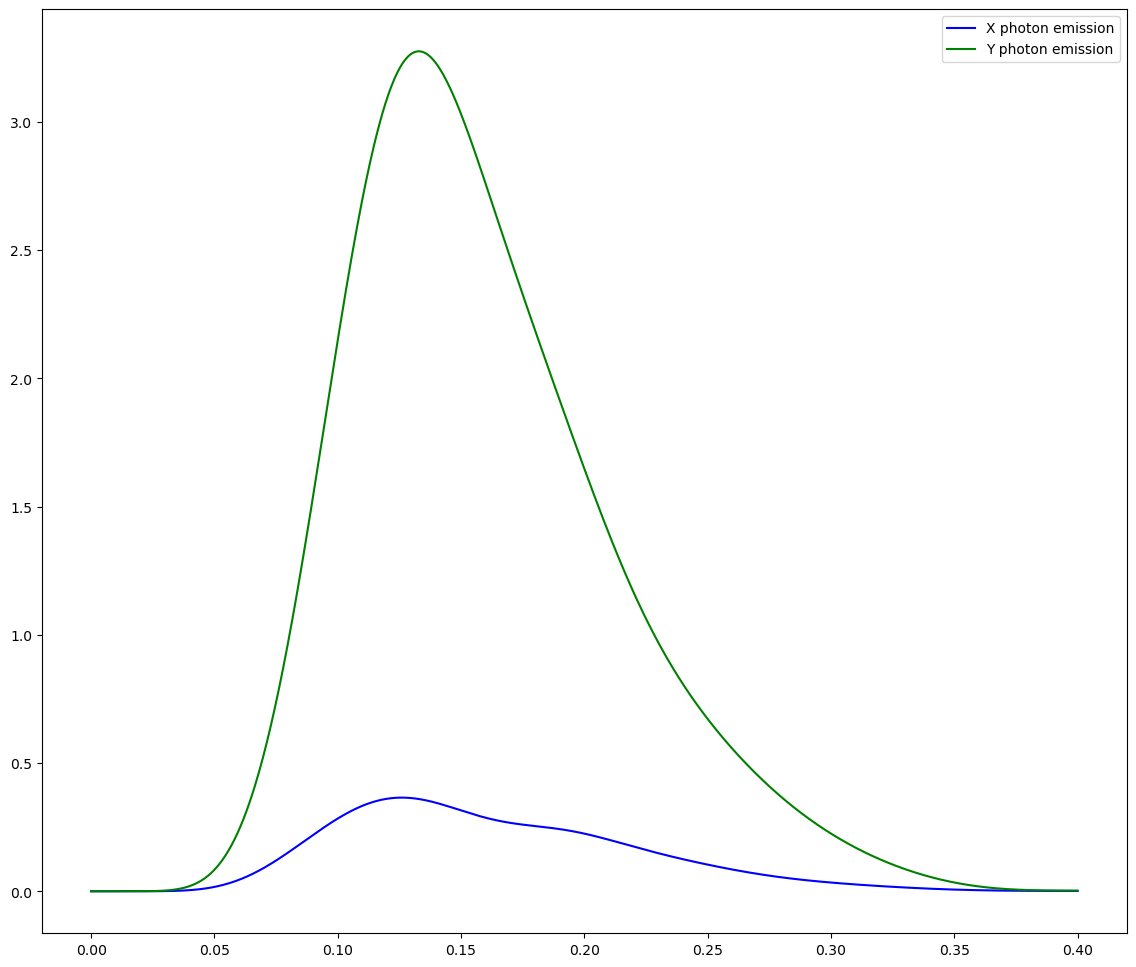

Total cavity emission in linear basis: 0.049 0.392
Total spontaneous emission from D1: 0.0
Total spontaneous emission from D2: 0.055


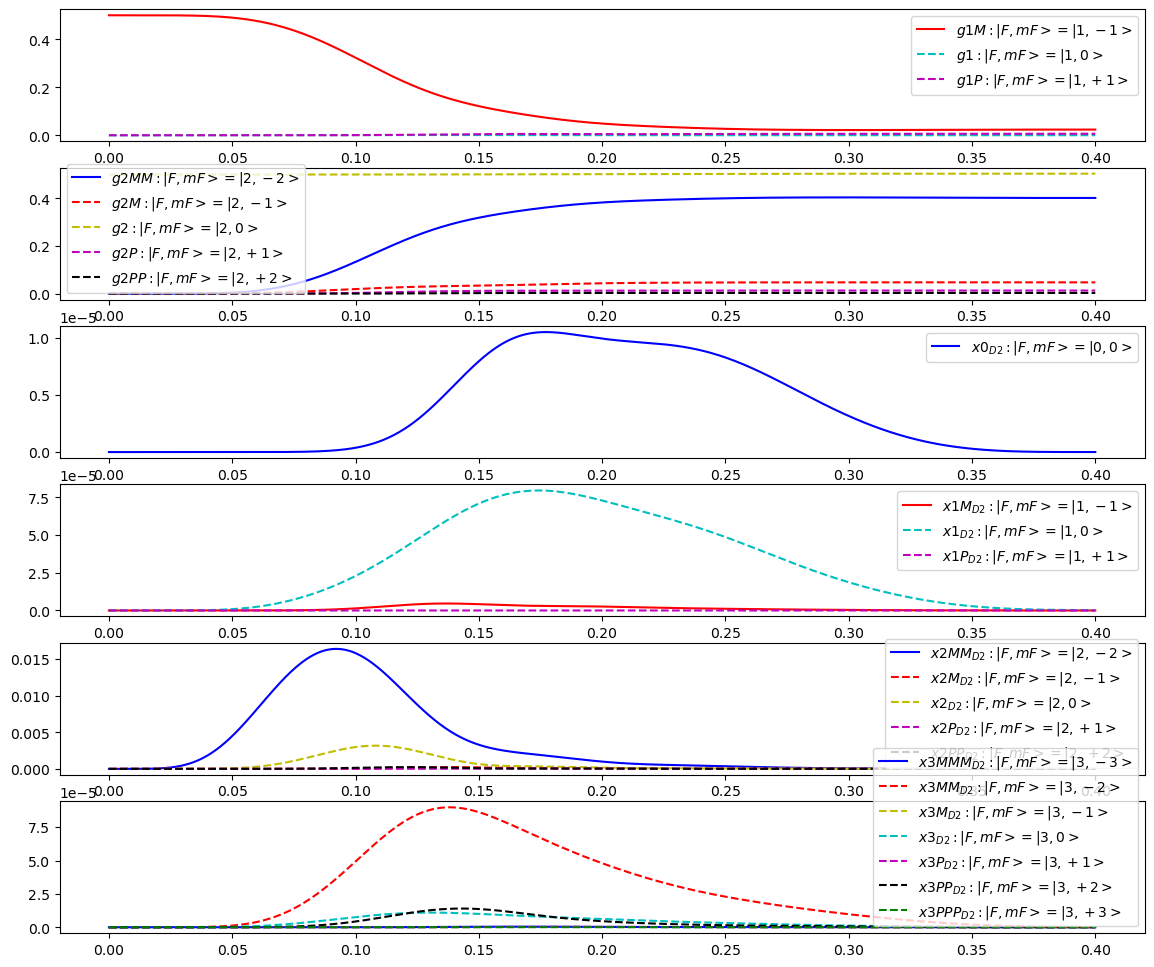

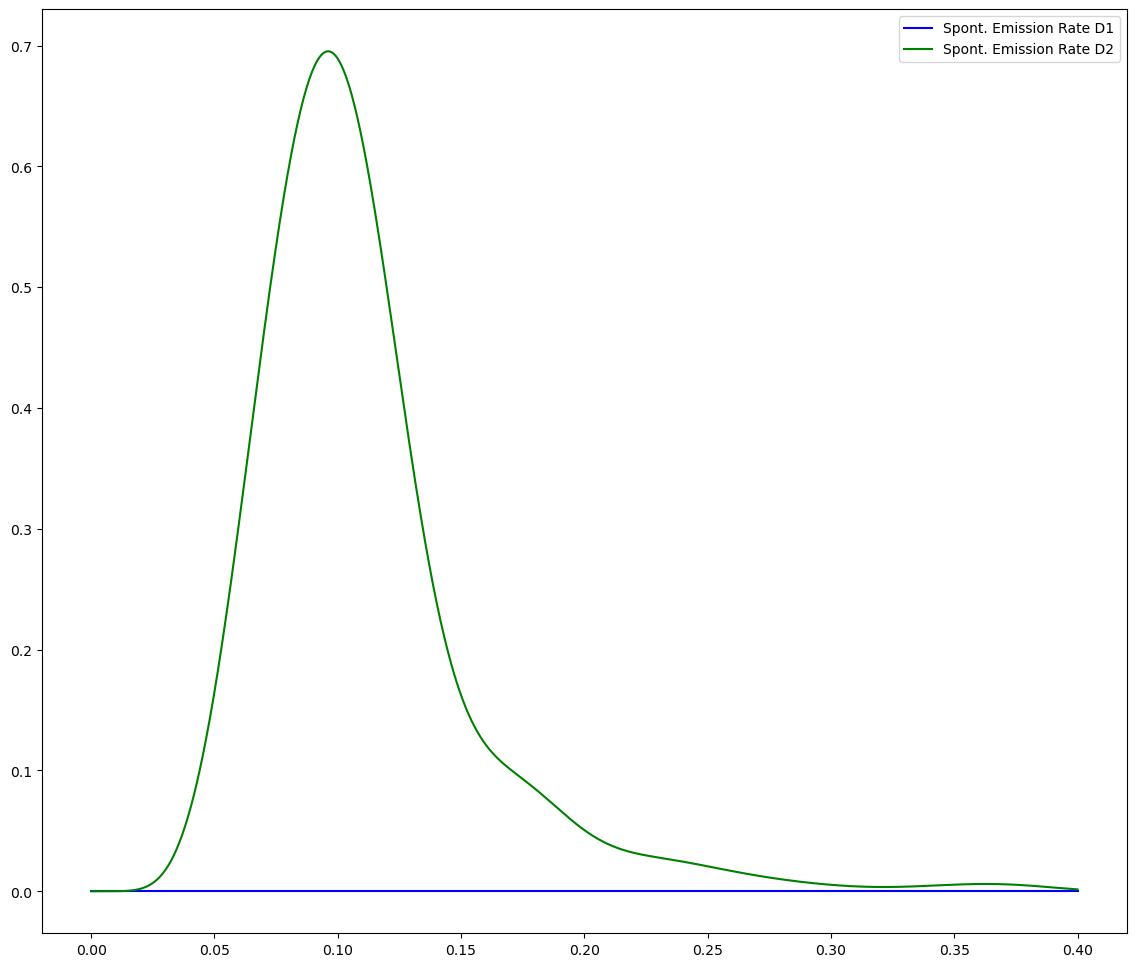

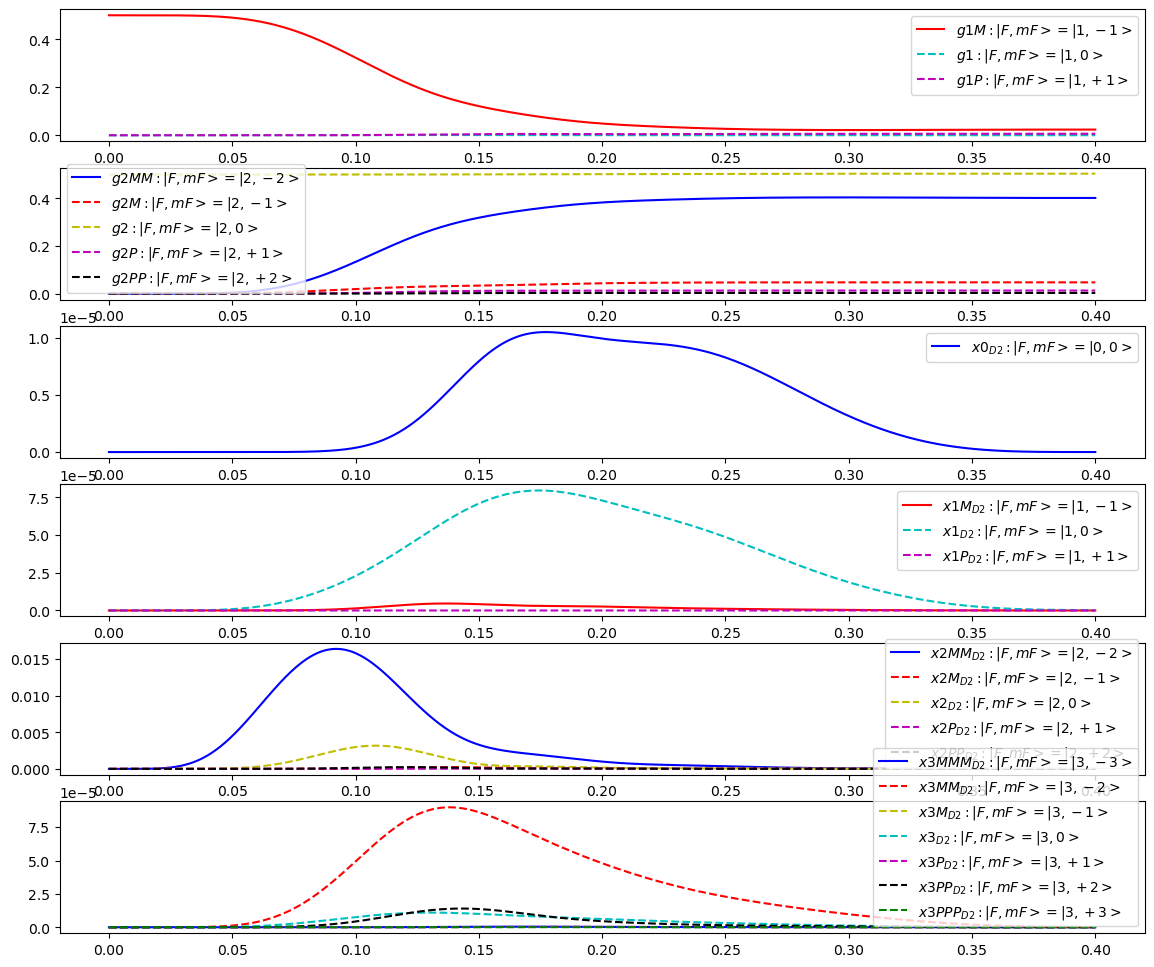

In [11]:
#pick the index of the Hamiltonian simulation you want to plot
ham_index=0
plot_output=output_states_list[ham_index]
plot_timelist=t_list[ham_index]

#plotting the results
#all plotting function require the following 4 arguments:
#ketbras: the configured ketbras of the system
#atomStates: the atomic groundstates of the system
#plot_output: the ouquantum object list outputted by the simulation
#plot_timelist: the list of timesteps for which the simulation was run
    #plotter_cavemission also requires the polarisation arguments phi1, phi2, alpha, beta for the desired additional cavity polarisation basis
    #plotter_spontdecay_channels requires no additional arguments
    #plotter_atomstate_population requires a Boolean as to whether to include the excited state population relevant for the D1 transitions
#define alternaive cavity polarisation basis, by default this is circular:
alpha=np.sqrt(1/2)
phi1=np.pi/2
phi2=0    

plotter_cavemission(ketbras, atomStates, plot_output, plot_timelist,kappa)
rb_atom.plotter_spontdecay_channels( atomStates, plot_output,plot_timelist)
rb_atom.plotter_atomstate_population(ketbras, plot_output,plot_timelist, False)



Total spontaneous emission from x2MM to g1M: 0.023


/Users/janoleernst/Desktop/DPhil/Simulations/Code/rb_photon_prod_dev_git/rb_photon_prod_dev/src/modules/atom_config.py:1107: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


0.022820721054385894

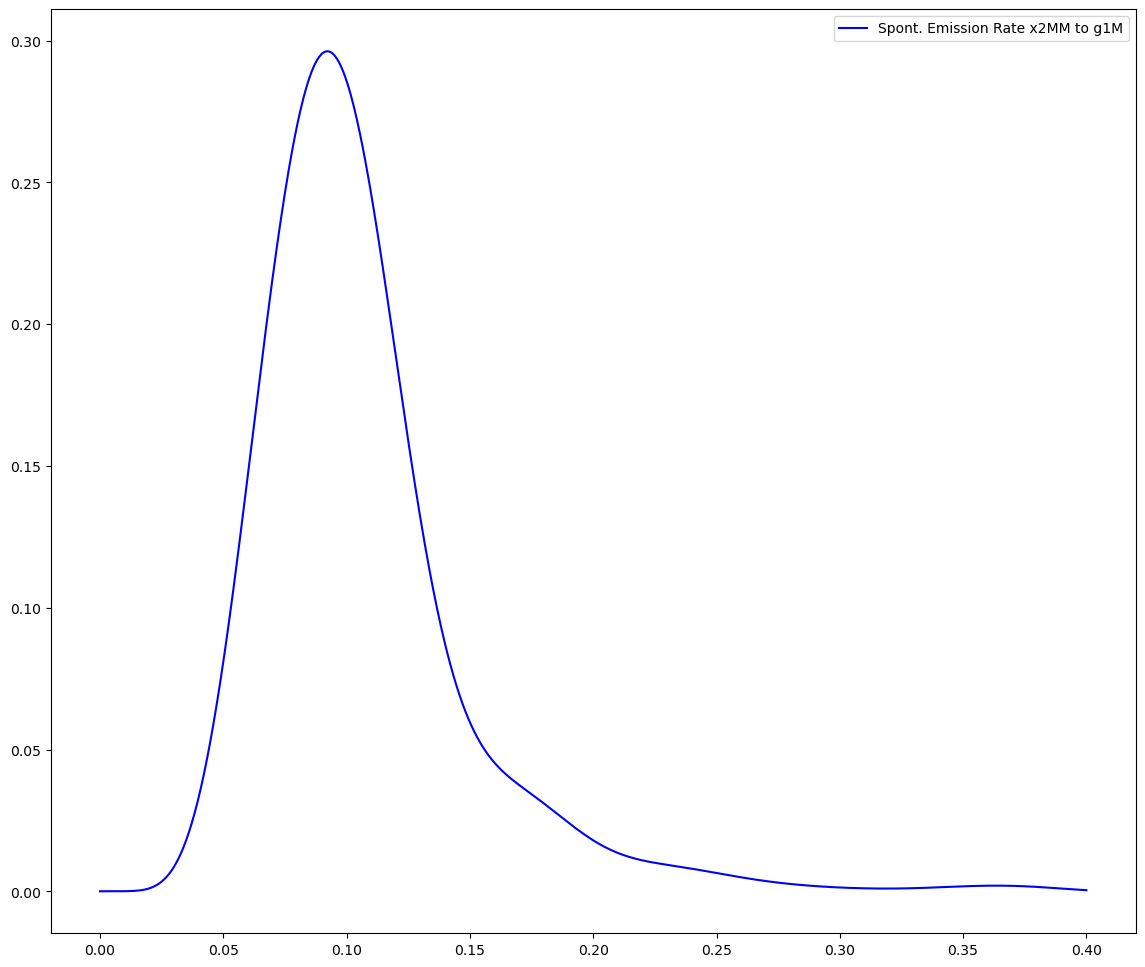

In [12]:
rb_atom.scattering_rate_of_transition(atomStates, "g1M", "x2MM",CGg1Mx2MM,False,plot_output, plot_timelist, _plot=True)